# Speech Recognition using CDHMMs

In [4]:
import os
import MFCC
import re
import random

import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

## Sampling from a Gaussian Mixture Model Hidden Markov Model

The function `sample_gmmhmm` accepts an integer $T$, and draws $T$ samples from a GMMHMM.

We draw $T=900$ samples from the GMMHMM, then use `sklearn.decomposition.PCA` with 2 components to plot the observations in two-dimensional space. 

In [5]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    N = 3
    K = 5
    M = 4
    
    ## Define the GMMHMM parameters
    # NxN transition matrix 
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
    # NxK collection of component weights
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])
    # NxKxM collection of component means
    means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) 
                            for i in range(3)])
    # NxKx(MxM) collection of component covariance matrices       
    covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) 
                            for i in range(5)] for j in range(3)])
    # (N,) ndarray initial state distribution 
    pi = np.array([.15, .15, .7])
    
    # initialize the sequence of states and observations
    states = np.zeros(T, dtype = np.int64)
    obs = np.zeros((T, M))
    states[0] = np.random.choice(N, p=pi)
    y0 = np.random.choice(K, p=weights[states[0]])
    obs[0] = np.random.multivariate_normal(means[states[0], y0, :], covars[states[0], y0, :, :])

    # sample the states and observations
    for t in range(1, T):
        states[t] = np.random.choice(N, p=A[states[t-1]])
        obs[t] = np.random.multivariate_normal(means[states[t], np.random.choice(K, p=weights[states[t]])], 
                                               covars[states[t], np.random.choice(K, p=weights[states[t]])])
    return states, obs

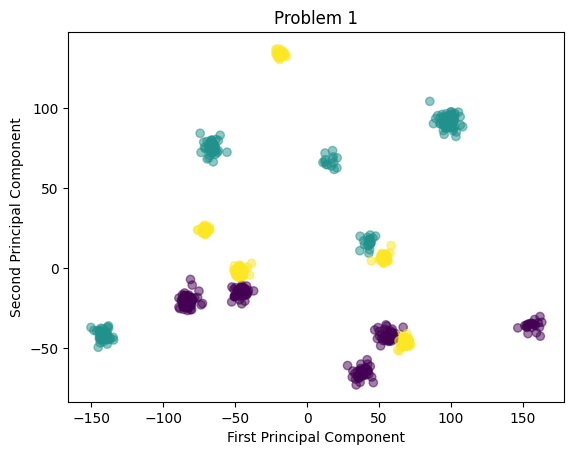

In [6]:
T = 900
states, obs = sample_gmmhmm(T)

pca = PCA(n_components = 2)
pca_obs = pca.fit_transform(obs)

# plot
plt.figure()
plt.scatter(pca_obs[:,0], pca_obs[:,1], c=states, alpha=0.5)
plt.title("Problem 1")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

## Speech Recognition

We will create a speech recognition system for the vocabulary of the following five words/phrases: "biology", "mathematics", "political science", "psychology", and "statistics".

The `Samples` folder contains 30 recordings for each of the words/phrases in the vocabulary.
These audio samples are 2 seconds in duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed integers in WAV format. 
For each of the words, we create a list holding the MFCC coefficients of the recordings of that word.

The function `scipy.io.wavfile.read` loads the sound files, and the function `extract` in `MFCC.py` implements the MFCC coefficient algorithm.

In [7]:
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore", category=wavfile.WavFileWarning)


# get all the filenames
first  = True
recordings = {}
for filename in os.listdir("Samples"):
    samplerate, sound_data = wavfile.read("Samples/" + filename)
    coefficients = MFCC.extract(sound_data)
    word = filename.split()[0]
    if word not in recordings:
        recordings[word] = [coefficients,]
    else:
        recordings[word].append(coefficients)

## Training

For each word, we randomly split the list of MFCCs into a training set of 20 samples and a test set of the remaining 10 samples.

We use the training sets to train GMMHMMs on each word in the vocabulary.
For each word in the vocabulary, we train 10 GMMHMMs on the training set, using `n_components=5`.
We keep the model with the highest log-likelihood for each word.

In [9]:
import numpy as np
from hmmlearn import hmm

# create train and test sets
train = {}
test = {}
models = {}
num_models = 10
for key in recordings.keys():
    # randomly select 20 elements to be in the train set
    train[key] = random.sample(recordings[key], 20)
    # the rest will be in the test set
    test[key] = [item for item in recordings[key] if not any(np.array_equal(item, x) for x in train[key])]

    data = train[key]
    # hmmlearn expects the data to be in a single array:
    data_collected = np.vstack(data)
    # To separate the sequences, it requires the length of each:
    lengths = [item.shape[0] for item in data]
    print("\nTraining for", key, end=": ")

    best_log = -np.inf
    for i in range(num_models):
        # Initialize and train the model
        model = hmm.GMMHMM(n_components=5, covariance_type="diag")
        model.fit(data_collected, lengths=lengths)
        # Check the log-likelihood
        log_likelihood = model.monitor_.history[-1]
        if log_likelihood > best_log:
            best_log = log_likelihood
            best_model = model
        print(i, end=", ")
    models[key] = best_model


Training for Biology: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
Training for Mathematics: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
Training for PoliticalScience: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
Training for Psychology: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
Training for Statistics: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

## Prediction

We write `predict` function for your speech recognition model.
In this function:
 - We accept the MFCC coefficients of the speech sample to be predicted.
 - We find the log probability density of the coefficients for each word's GMMHMM.
 - We return the word with the highest probability as the speech recognition model's prediction.

In [12]:
def predict(mfcc_coeffs):
    """
    Predict the word from the given mfcc coefficients
    
    Parameters
    ----------
    mfcc_coeffs : ndarray of shape (M,)
        The mfcc coefficients for the word to be predicted
        
    Returns
    -------
    word : str
        The predicted word
    """
    # find the log probability density of the given mfcc coefficients
    log_prob = {}
    for key in models.keys():
        log_prob[key] = models[key].score(mfcc_coeffs)
    
    # return the word with the highest probability
    return max(log_prob, key=log_prob.get)

## Evalution

For each of the five test sets, we call the `predict` function on each sample, and find the proportion of each test set that the model predicts correctly.

In [13]:
for key in test.keys():
    correct = 0
    for item in test[key]:
        if predict(item) == key:
            correct += 1
    print("Accuracy for", key, ":", correct/len(test[key]))

Accuracy for Biology : 0.9
Accuracy for Mathematics : 1.0
Accuracy for PoliticalScience : 1.0
Accuracy for Psychology : 1.0
Accuracy for Statistics : 1.0


The model performs well on this dataset